# XGBoost Algorithm - PCA analysis
---
##### Created by Carlos Moreno, Elizabeth Khan, Frances Leung, Jeffrey Laughman 
_Last Updated on 7/14/2022_


We are importing the same libraries as the original notebook and including XGBboost

In [ ]:
# !pip install xgboost

In [1]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# XGBoost
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model, decomposition, datasets
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import PrecisionRecallDisplay

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import datetime
from datetime import datetime
import os
import matplotlib.pyplot as plt
import math
import random

# my script
from w210_model_library import print_confusion_matrix
from w210_model_library import modelresults, modelresults_2, crossvalidation,assignRisk 
from w210_model_library import newPred, riskdistribution, fattrtype, importance_attr

# random.seed(1234)
#dirname = '../model/'
dirname = '../model/'
dirgroups = '../groups/'

### 1. Read in file

In [2]:
finEvents = pd.read_csv(dirname+"data_model1_365.csv")

# finEvents = pd.read_csv(dirgroups+"data365_sh_county_gr.csv")


finEvents.isnull().values.any(), finEvents.isnull().sum().sum()

(False, 0)

In [3]:
finEvents = finEvents.dropna()
finEvents.isnull().values.any(), finEvents.isnull().sum().sum()

(False, 0)

## Select Group of Interest

In [4]:
# np.array(finEvents.columns)

In [5]:
# finEvents["RN_sh"].unique()
# print(len(finEvents))

In [6]:
# gr1 = finEvents[~finEvents["RN_sh"].isnull()]
# print(len(gr1))
# gr1 = gr1[gr1["RN_sh"]>2]
# print(len(gr1))

### 2. Select Features

We do not have to scale features are we are using XGBoost which does not require features to be scaled prior to running the algorithm.


In [7]:
# shvars = ['l25', 'l50', 'l75', 'l100', 'l150','l200', 'l250', 'l300', 'l500', 'l750', 'l1000',
#           'Y25', 'Y50', 'Y75', 'Y100', 'Y150', 'Y200', 'Y250', 'Y300', 'Y500','Y750', 'Y1000']

# satvars = ['AnnualCrop', 'Forest','HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 
#            'PermanentCrop', 'Residential', 'River', 'SeaLake']

# wsvars = ['y1_mean_prc', 'y1_max_prc', 'y1_mean_tmp', 'y1_max_tmp', 'y1_min_tmp',
#           'y2_mean_prc', 'y2_max_prc', 'y2_mean_tmp', 'y2_max_tmp', 'y2_min_tmp', 
#           'y3_mean_prc', 'y3_max_prc', 'y3_mean_tmp', 'y3_max_tmp', 'y3_min_tmp']

# wsvars2 = ['y1_mean_prc', 'y1_max_prc', 'y1_max_tmp', 'y1_min_tmp',
#           'y2_mean_prc', 'y2_max_prc', 'y2_max_tmp', 'y2_min_tmp', 
#           'y3_mean_prc', 'y3_max_prc', 'y3_max_tmp', 'y3_min_tmp']

# wsrolling = ['rolling_7_precip', 'rolling_15_precip', 'rolling_30_precip',
#              'rolling_60_precip', 'rolling_90_precip']

# wsvars3 = ['y1_mean_prc', 'y1_max_prc', 'y1_mean_tmp', 'y1_max_tmp', 'y1_min_tmp']

# karst1 = ['gridcode']

# soilattr = ['Calcium Carbonate', 'Soil Health Organic Matter', 'Percent Clay', 
#             'Gypsum',
#             'Percent Sand','Percent Silt', 'Available Water Storage']

# x_variables = shvars  + satvars + wsrolling + karst1 + soilattr + wsvars

# # x_variables = shvars  + wsvars2 + karst1 + soilattr

# attrdict = {"Sinkhole": shvars, "Satellite": satvars, "Weather Rolling": wsrolling,
#             "Karst": karst1, "Soil": soilattr, "Weather Yearly": wsvars}

# print(x_variables)
# print(len(x_variables))


In [8]:
# dfvars = pd.read_csv(dirname+"attr60.csv")
# dfvars = pd.read_csv(dirname+"attr70.csv")
# dfvars = pd.read_csv(dirname+"attr80.csv")
# dfvars = pd.read_csv(dirname+"attr90.csv")
# dfvars = pd.read_csv(dirname+"attr95.csv")
dfvars = pd.read_csv(dirname+"attr100.csv")


x_variables = list(dfvars["attribute"].unique())
len(x_variables)

60

In [9]:
features = finEvents[x_variables]

# features = gr1[x_variables]

# One-hot encode the data using pandas get_dummies
# features = pd.get_dummies(features)

In [10]:
np.random.seed(42)

X = np.array(features)
Y = np.array(finEvents["Sinkhole"])
Group = np.array(finEvents["Group"])

shuffle = np.random.permutation(np.arange(X.shape[0]))

X, Y, Group = X[shuffle], Y[shuffle], Group[shuffle]

# Define sizes for train, development and test data (0.5, 0.2, 0.3)
train = 0.80
val = 0
test = 1- train

num_images = len(Y)
train_size = int(round(num_images * train,0))
val_size = int(round(num_images * val,0))
test_size = num_images - train_size - val_size

print(train_size, val_size, test_size)

test_data, test_labels, test_group = X[train_size+val_size:], Y[train_size+val_size:], Group[train_size+val_size:]
# val_data, val_labels = X[train_size:train_size+val_size], Y[train_size:train_size+val_size]
train_data, train_labels, train_group = X[:train_size], Y[:train_size], Group[:train_size]

print(len(test_data), len(train_data), len(train_group))

np.count_nonzero(Y == 0), np.count_nonzero(Y == 1)

178 0 44
44 178 178


(110, 112)

## PCA Analysis

In [11]:
#Helper function to show line of cummulative variance explained by each pca
def varplot2(exp_var_ratio):
    
    cum_var_exp= np.cumsum(exp_var_ratio)

    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(10, 8))
        #plt.step(range(len(exp_var_ratio)), cum_var_exp, where='mid',label='cumulative explained variance')
        plt.plot(range(len(exp_var_ratio)), cum_var_exp, label='cumulative explained variance')
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal components')
        plt.legend(loc='best')
        plt.tight_layout()

In [12]:
fp_pca = PCA()
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

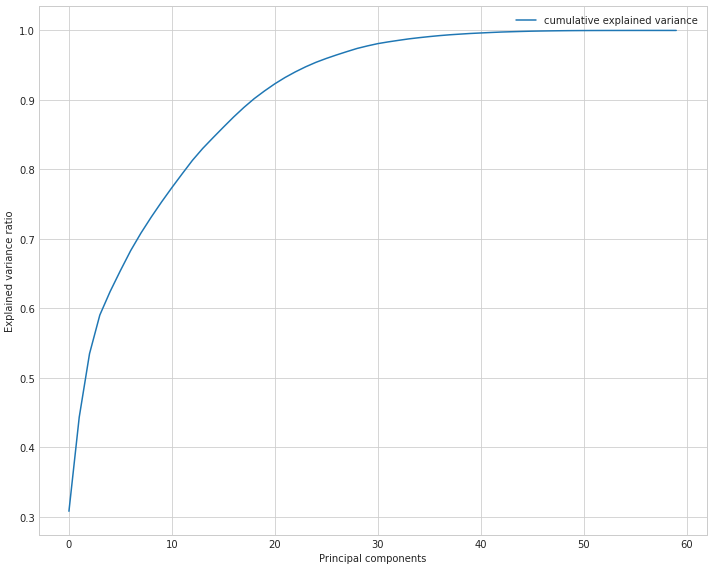

In [13]:
train_data_pca = fp_pca.fit_transform(train_data)

df_summary = pd.DataFrame({"Dimension": range(1,fp_pca.explained_variance_ratio_.shape[0]+1),
                           "Var Prop Exp": fp_pca.explained_variance_ratio_,
                            "Var Cum Prop Exp (%)": np.cumsum(fp_pca.explained_variance_ratio_)})
#varplot1(p1_pca.explained_variance_)
varplot2(fp_pca.explained_variance_ratio_)

In [14]:
np.cumsum(fp_pca.explained_variance_ratio_)[35]

0.9911294636336425

In [15]:
k_list = [0, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60]

df_summary = pd.DataFrame({"Dimension": range(1,fp_pca.explained_variance_ratio_.shape[0]+1),
                          "Var Prop Exp": fp_pca.explained_variance_ratio_,
                          "Var Cum Prop Exp (%)": np.cumsum(fp_pca.explained_variance_ratio_)})

#df_summary["Cum 2"] = df_summary['Var Prop Exp'].cumsum()

print(df_summary[df_summary['Dimension'].isin(k_list)])

    Dimension  Var Prop Exp  Var Cum Prop Exp (%)
0           1  3.080705e-01              0.308070
1           2  1.354294e-01              0.443500
2           3  9.130376e-02              0.534804
3           4  5.561276e-02              0.590416
4           5  3.381918e-02              0.624236
9          10  2.168550e-02              0.753185
19         20  1.106120e-02              0.912929
29         30  3.636065e-03              0.977736
39         40  9.210885e-04              0.995641
49         50  1.299152e-04              0.999745
59         60  2.605708e-33              1.000000


### Selecting Top PCA components

In [16]:
#USE THIS CODE WHEN SELECTING TOP 100 PRINCIPAL COMPONENTS FOR THE MODELS ONLY
n_components = 34
pca_final = PCA(n_components=n_components)
train_data = pca_final.fit_transform(train_data)
test_data = pca_final.transform(test_data)

### 3. Hyperparameter Tuning
This section is where the cross validation happens for XGBoost to determine the optimal number for hyperparameters. We will find out the best parameters to include in the final XGBoost model. By default, we are using 5 folds.

In [17]:
def tune_xgboost(train_data, train_labels, folds=5):
    # parameters to iterate through using grid search cv
    params = {
        'max_depth': range (6, 20, 2),
        'learning_rate': [0.001, 0.01, 0.1, 0.2],
        #'lambda': [.25, .2, .1 ,.001],
        'eta':[.001, .1, .2, .3], #equivalent to learning rate; also can help with overfitting
        'subsample': [.25], #helps with overfitting
        'gamma': [0.1, 0.2],
        'alpha': [0.1, 0.2]}

    # list of names of parameters for looping purposes
    param_names = ['max_depth', 'learning_rate','gamma', 'alpha']
    
    #intialize xgboost model
    xgb_2 = xgb.XGBClassifier(objective= 'binary:logistic',seed=18)

    # initalize gridsearch cv to search identify optimal parameters of predefined XGBoost algorithm designated number of folds
    clf = GridSearchCV(estimator=xgb_2, param_grid = params, scoring='roc_auc', n_jobs = -1, cv = folds,verbose=True)
    # fit XGBoost model to parameters specified above
    clf.fit(train_data,train_labels)
    best_params = clf.best_params_
    print(best_params)

    return clf, best_params

In [18]:
clf, best_params = tune_xgboost(train_data, train_labels)

Fitting 5 folds for each of 448 candidates, totalling 2240 fits
{'alpha': 0.2, 'eta': 0.001, 'gamma': 0.1, 'learning_rate': 0.001, 'max_depth': 6, 'subsample': 0.25}


In [19]:
best_params

{'alpha': 0.2,
 'eta': 0.001,
 'gamma': 0.1,
 'learning_rate': 0.001,
 'max_depth': 6,
 'subsample': 0.25}

### 4. Train XGBoost model
We are taking the best parameters from the previous section and then using them in the best xgboost model. We include `early stopping` here to prevent overfitting.

In [20]:
def best_xgb_model(train_data, train_labels, best_params):
    # intialize xgboost using best parameters identified from previous step
    xgb1 = xgb.XGBClassifier(objective= 'binary:logistic', 
#                              eval_metric='logloss',
                             max_depth = best_params['max_depth'],
                             learning_rate = best_params['learning_rate'],
                             gamma = best_params['gamma'],
                             alpha = best_params['alpha'],
                             eta = best_params['eta'],
                             subsample = best_params['subsample'],
                             nthread=4,seed=42)
    eval_set = [(test_data, test_labels)]
    # fit model
    xgb1.fit(train_data, train_labels, early_stopping_rounds=4, eval_metric="logloss", eval_set=eval_set, verbose=True)

    return xgb1

In [21]:
xgb1 = best_xgb_model(train_data, train_labels, best_params)

[0]	validation_0-logloss:0.69289
[1]	validation_0-logloss:0.69269
[2]	validation_0-logloss:0.69263
[3]	validation_0-logloss:0.69254
[4]	validation_0-logloss:0.69251
[5]	validation_0-logloss:0.69233
[6]	validation_0-logloss:0.69223
[7]	validation_0-logloss:0.69210
[8]	validation_0-logloss:0.69210
[9]	validation_0-logloss:0.69199
[10]	validation_0-logloss:0.69193
[11]	validation_0-logloss:0.69181
[12]	validation_0-logloss:0.69180
[13]	validation_0-logloss:0.69184
[14]	validation_0-logloss:0.69192
[15]	validation_0-logloss:0.69187
[16]	validation_0-logloss:0.69183


/Users/carlosmoreno/opt/anaconda3/envs/w210/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/carlosmoreno/opt/anaconda3/envs/w210/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


### 5. Evaluate XGBoost Model

We use the confusion matrix and evaluation metrics accuracy, precision, recall, and F1 Score to evaluate the model.

In [22]:
predictions = xgb1.predict(test_data)

In [23]:
tn, fp, fn, tp = confusion_matrix(test_labels, predictions, labels=[0, 1]).ravel()

print('True Positive', tp)
print('True Negative', tn)
print('False Positive', fp)
print('False Negative', fn)

True Positive 14
True Negative 12
False Positive 10
False Negative 8


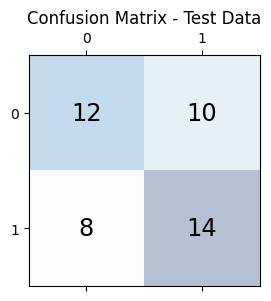

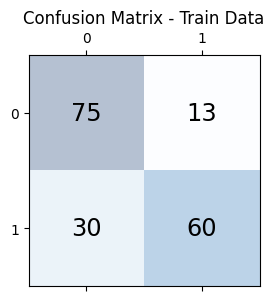

In [24]:
predictions = xgb1.predict(test_data)

print_confusion_matrix(test_labels, predictions, "Confusion Matrix - Test Data")
print_confusion_matrix(train_labels, xgb1.predict(train_data), "Confusion Matrix - Train Data")

In [25]:
def get_metrics(train_data,train_labels, test_data, test_labels, model):
    dfResults = pd.DataFrame()
    dfPred = {}
    
    scenarios = ["Train", "Test"]
    accuracy1 = []
    precision = []
    recall = []
    f1_score_list = []
    f1_scr_weighted = []
    
    for scenario in scenarios:
        
        data = []
        labels = []
        
        if scenario == "Train":
            data = train_data
            labels = train_labels
        else:
            data = test_data
            labels = test_labels
        
        predictions = model.predict(data)
        
        accuracy1.append(accuracy_score(labels, predictions)) 
        precision.append(precision_score(labels, predictions))
        recall.append(recall_score(labels, predictions))
        f1_score_list.append(f1_score(labels, predictions))
        f1_scr_weighted.append(metrics.f1_score(labels, predictions, average="weighted"))
        dfPred[scenario] = predictions

    index = ["Accuracy", "Precision", "Recall", "F1_score", "F1_score_weighted"]
    
    results = [accuracy1, precision, recall, f1_score_list, f1_scr_weighted]
    results = [accuracy1, precision, recall, f1_score_list, f1_scr_weighted]
    dfResults = pd.DataFrame(results, columns=scenarios, index=index)


    return(dfResults, dfPred)

In [26]:
dfResults, dfPred = get_metrics(train_data,train_labels, test_data, test_labels, xgb1)

In [27]:
dfResults

,Train,Test
Accuracy,0.758427,0.590909
Precision,0.821918,0.583333
Recall,0.666667,0.636364
F1_score,0.736196,0.608696
F1_score_weighted,0.756469,0.590062


In [ ]:
dfprobTrain = riskdistribution(test_data, test_labels, test_group, xgb1.predict(test_data), 0.5,0.3,xgb1)
pivot = np.round(pd.pivot_table(dfprobTrain, values='Value', 
                                index='Label', 
                                columns='Risk', 
                                aggfunc='count'),2)
pivot

In [ ]:
def createranks(df):
    df["dif_prob"] = df["SH"] - df["No_SH"]
    minp = df["dif_prob"].min()
    df["dp_scale"] = df["dif_prob"] - minp
    
    df["dp_range"] = df["dp_scale"].rank(pct = True)
    df["Rank_10"] = df.apply(lambda row: round(row["dp_range"]*10,0), axis=1)
    df["Rank_5"] = df.apply(lambda row: round(row["Rank_10"]/2,0), axis=1)
    df["Rank_3"] = df.apply(lambda row: round(row["Rank_10"]/3,0), axis=1)
    df["Num"] = 1
    
    return df

In [ ]:
dfprobTrain = createranks(dfprobTrain)

In [ ]:
dfprobTrain.head(3)

In [ ]:
def ranktable(df, colrank):
    rank1 = df.pivot_table('Num', index='Label', 
                          columns=colrank,  
                          aggfunc='sum', fill_value=0, 
                          margins=True)
    l = list(rank1.loc['All',:])/rank1.loc['All','All']*100
    rank1.loc[len(rank1.index)] = list(l)
    rank1.rename({rank1.index[-1]: "Prc_Total"}, inplace=True)
    
    return rank1

In [ ]:
def grrank(df, row, color):
    fig = plt.figure(figsize = (10, 5))
    plt.bar(list(df.columns)[0:len(df.columns)-1], 
            list(df.loc[row,:])[0:len(list(df.loc[row,:]))-1], 
            color =color, width = 0.4)

In [ ]:
r10 = ranktable(dfprobTrain, "Rank_10")
r10

In [ ]:
grrank(r10, "Prc_Total", "red")

In [ ]:
r5 = ranktable(dfprobTrain, "Rank_5")
r5

In [ ]:
grrank(r5,"Prc_Total", "blue")

In [ ]:
r3 = ranktable(dfprobTrain, "Rank_3")
r3

In [ ]:
grrank(r3, "Prc_Total", "red")

### 6. Next Steps

We can use this model to produce a probability score which that can be converted in to our risk score. See function and example below.

In [ ]:
# Function to Create DataFrame with High, Medium, Low Risk Distribution for a given data
def riskdistribution1(data, labels, groups, pipeline):
    
    dfprob = pd.DataFrame()
    dfprob["Label"] = labels
    dfprob["No_SH"] = pipeline.predict_proba(data)[:,0]
    dfprob["SH"] = pipeline.predict_proba(data)[:,1]
    dfprob["Prediction"] = pipeline.predict(data)
    dfprob["Group"] = groups
    
    return (dfprob)

In [ ]:
xgb_prob = riskdistribution1(test_data, test_labels, test_group, xgb1)
# pivot = np.round(pd.pivot_table(xgb_prob, values='Value', 
#                                 index='Label', 
#                                 columns='Group', 
#                                 aggfunc='count'),2)

In [ ]:
xgb_prob.to_csv(dirname+"xgb_pprob_80.csv", index=False)

In [ ]:
def get_probability_scores(input_data, model):
    #get probability scores for converting to risk score
    probs = model.predict_proba(input_data)
    return probs

In [ ]:
xgbprob = get_probability_scores(test_data,xgb1)
xgbprob

In [ ]:
importancedf = importance_attr(x_variables, xgb1, attrdict)

In [ ]:
xgb1.feature_importances_

In [ ]:
importancedf.groupby(["attr_type"], as_index=False)["importance"].agg({'attribute':'count', 'importance': 'sum'}).sort_values("importance", ascending=False)

In [ ]:
attr60 = importancedf[importancedf["CUMSUM_importance"] <0.61]
attr70 = importancedf[importancedf["CUMSUM_importance"] <0.71]
attr80 = importancedf[importancedf["CUMSUM_importance"] <0.81]
attr90 = importancedf[importancedf["CUMSUM_importance"] <0.91]
attr95 = importancedf[importancedf["CUMSUM_importance"] <0.96]
attr100 = importancedf
len(attr80), len(attr90), len(attr95)

In [ ]:
attr60.to_csv(dirname+"attr60.csv", index=False)
attr70.to_csv(dirname+"attr70.csv", index=False)
attr80.to_csv(dirname+"attr80.csv", index=False)
attr90.to_csv(dirname+"attr90.csv", index=False)
attr95.to_csv(dirname+"attr95.csv", index=False)
attr100.to_csv(dirname+"attr100.csv", index=False)

In [ ]:
print(len(attr70))

In [ ]:
importancedf.to_excel(dirname+"attr_importance_XGBOOST.xlsx", index=False)

In [ ]:
attr70.groupby(["attr_type"], as_index=False)["importance"].agg({'attribute':'count', 'importance': 'sum'}).sort_values("importance", ascending=False)

In [ ]:
attr90.groupby(["attr_type"], as_index=False)["importance"].agg({'attribute':'count', 'importance': 'sum'}).sort_values("importance", ascending=False)

In [ ]:
attr95.groupby(["attr_type"], as_index=False)["importance"].agg({'attribute':'count', 'importance': 'sum'}).sort_values("importance", ascending=False)